## REINFORCE

Based on the [following materials](https://towardsdatascience.com/policy-gradient-methods-104c783251e0).

<img src="https://static.packt-cdn.com/products/9781789345803/graphics/assets/9170409d-15f1-453b-816a-6f601a89fcf2.png"/>

In [490]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [491]:
env = gym.make('CartPole-v1')

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [492]:
obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n

In [493]:
HIDDEN_SIZE = 256
T = 0.1

# simpliest neural network
model = torch.nn.Sequential(
            torch.nn.Linear(obs_size, HIDDEN_SIZE),
            torch.nn.ReLU(),
            torch.nn.Linear(HIDDEN_SIZE, n_actions),
            torch.nn.Softmax(dim=0)
     )

learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [494]:
# hyperparameters
Horizon = 1000
MAX_TRAJECTORIES = 1000
gamma = 0.99
score = []

In [495]:
# for trajectory in tqdm(range(MAX_TRAJECTORIES)):
#     curr_state = env.reset()
#     done = False
#     transitions = [] 
#     # iterating the trajectory
#     for t in range(Horizon):
#         act_prob = model(torch.from_numpy(curr_state).float())
#         action = np.random.choice(np.array([0,1]), 
#                  p=act_prob.data.numpy())
#         prev_state = curr_state
#         curr_state, _, done, info = env.step(action) 
#         transitions.append((prev_state, action, t+1)) 
#         if done: 
#             break
#     # iters until fallen
#     score.append(len(transitions))
#     reward_batch = torch.Tensor([r for (s,a,r) in 
#                    transitions]).flip(dims=(0,)) 
#     batch_Gvals =[]
#     # interesting computation, isn't it?
#     for i in range(len(transitions)):
#         new_Gval=0
#         power=0
#         for j in range(i,len(transitions)):
#              new_Gval=new_Gval + ((gamma**power)*reward_batch[j]).numpy()
#              power+=1
#         batch_Gvals.append(new_Gval)

#     expected_returns_batch=torch.FloatTensor(batch_Gvals)
#     expected_returns_batch /= expected_returns_batch.max()

#     state_batch = torch.Tensor(np.array([s for (s,a,r) in transitions])) 
#     action_batch = torch.Tensor(np.array([a for (s,a,r) in transitions])) 

#     pred_batch = model(state_batch) 
#     prob_batch = pred_batch.gather(dim=1,index=action_batch
#                  .long().view(-1,1)).squeeze() 
#     # so, compute the gradient
#     loss= -torch.sum(torch.log(prob_batch)*expected_returns_batch) 
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

In [496]:
import scipy

def softmax_temperature(rewards):
    T = 100
    means = []
    # mean for each action
    for rew_list in rewards:
        means.append(np.mean(rew_list) / T)
     
    return scipy.special.softmax(means)

count_success = 0
for trajectory in tqdm(range(MAX_TRAJECTORIES)):
    curr_state = env.reset()
    done = False
    transitions = [] 
    # iterating the trajectory
    for t in range(Horizon):
        act_prob = model(torch.from_numpy(curr_state).float()).data.numpy()
        # act_prob = softmax_temperature(act_prob.data.numpy())
        if count_success / MAX_TRAJECTORIES > 0.8:
            action = np.argmax(act_prob)
        else:
            action = np.random.choice(np.array([0,1]), 
                 p=act_prob)
            # action = np.random.choice(np.array([0,1]), 
            #      p=act_prob.data.numpy())
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) 
        transitions.append((prev_state, action, t+1)) 
        if done:
            break
        if t == Horizon - 1:
            count_success += 1
    # iters until fallen
    score.append(len(transitions))
    reward_batch = torch.Tensor([r for (s,a,r) in 
                   transitions]).flip(dims=(0,)) 
    
    # fast computations using top-down approach
    batch_Gvals = []
    batch_Gvals = [reward_batch[len(transitions) - 1].numpy()]
    for i in range(1, len(transitions)):
        batch_Gvals.append(
            batch_Gvals[i - 1] * gamma + reward_batch[len(transitions) - i - 1].numpy()
            )
    batch_Gvals.reverse()

    expected_returns_batch=torch.FloatTensor(batch_Gvals)
    expected_returns_batch /= expected_returns_batch.max()

    state_batch = torch.Tensor(np.array([s for (s,a,r) in transitions])) 
    action_batch = torch.Tensor(np.array([a for (s,a,r) in transitions])) 

    pred_batch = model(state_batch) 
    prob_batch = pred_batch.gather(dim=1,index=action_batch
                 .long().view(-1,1)).squeeze() 
    # so, compute the gradient
    loss= -torch.sum(torch.log(prob_batch) * expected_returns_batch) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

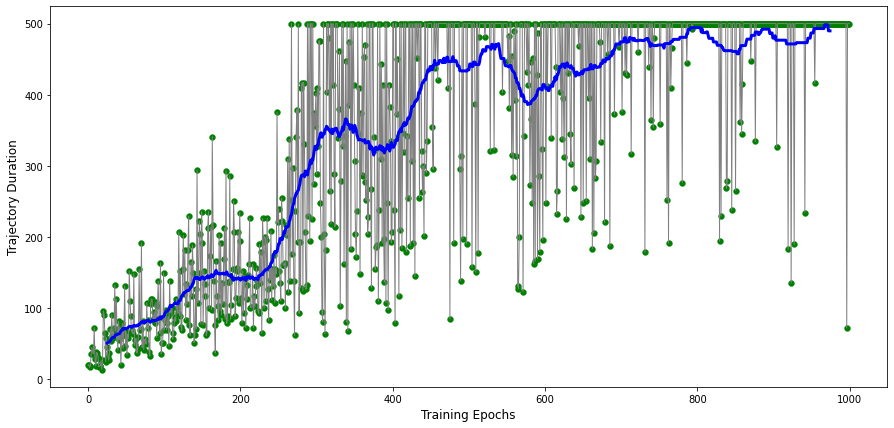

In [497]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)

    shift = int(N/2)
    for i in range(shift, conv_len + shift):
        y[i - shift] = kernel @ x[i-shift:i+shift]
        y[i - shift] /= N
    return y

score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(np.arange(25, 25 + len(avg_score)), avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)
plt.show()

### Task

1. Change computation of `batch_Gvals`, so that it works faster

> Сделано, применена динамика.

2. Sometimes even if we proceed training for thousands of epochs, we may face situations when cart pole does not run for all the time. What is the reason? Change the code in a way cart pole does not fall quickly in the late simulations. 


> Потому что он скатывается в локальный минимум. Но нам надо как-то заставить его при хороших единичных действиях заставить их запоминать, т.е. стараться меньше выбирать действие по вероятности, а больше то, что соответствует праивльному действию. Сейчас я просто выбираю действие с максимальной вероятностью, если какое-то количество эпизодов каретка не падает.



## Actor-Critic

Based on the [materials](https://github.com/nikhilbarhate99/Actor-Critic-PyTorch).

<img src="https://github.com/nikhilbarhate99/Actor-Critic/raw/master/gif/gif3.gif">

In [ ]:
!pip install gym[box2d]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.affine = nn.Linear(8, 128)
        
        self.action_layer = nn.Linear(128, 4)
        self.value_layer = nn.Linear(128, 1)
        
        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        state = torch.from_numpy(state).float()
        state = F.relu(self.affine(state))
        
        state_value = self.value_layer(state)
        
        action_probs = F.softmax(self.action_layer(state))
        action_distribution = Categorical(action_probs)
        action = action_distribution.sample()
        
        self.logprobs.append(action_distribution.log_prob(action))
        self.state_values.append(state_value)
        
        return action.item()
    
    def calculateLoss(self, gamma=0.99):
        
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss
    
    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

In [ ]:
def test(n_episodes=5, name='LunarLander_TWO.pth'):
    env = gym.make('LunarLander-v2')
    policy = ActorCritic()
    
    policy.load_state_dict(torch.load('./preTrained/{}'.format(name)))
    
    render = True
    save_gif = False

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        running_reward = 0
        for t in range(10000):
            action = policy(state)
            state, reward, done, _ = env.step(action)
            running_reward += reward
            if render:
                 env.render()
                 if save_gif:
                     img = env.render(mode = 'rgb_array')
                     img = Image.fromarray(img)
                     img.save('./gif/{}.jpg'.format(t))
            if done:
                break
        print('Episode {}\tReward: {}'.format(i_episode, running_reward))
    env.close()

In [ ]:
import torch
import torch.optim as optim
import gym

def train():
    # Defaults parameters:
    #    gamma = 0.99
    #    lr = 0.02
    #    betas = (0.9, 0.999)
    #    random_seed = 543

    render = False
    gamma = 0.99
    lr = 0.02
    betas = (0.9, 0.999)
    random_seed = 543
    
    torch.manual_seed(random_seed)
    
    env = gym.make('LunarLander-v2')
    env.seed(random_seed)
    
    policy = ActorCritic()
    optimizer = optim.Adam(policy.parameters(), lr=lr, betas=betas)
    print(lr,betas)
    
    running_reward = 0
    for i_episode in range(0, 10000):
        state = env.reset()
        for t in range(10000):
            action = policy(state)
            state, reward, done, _ = env.step(action)
            policy.rewards.append(reward)
            running_reward += reward
            if render and i_episode > 1000:
                env.render()
            if done:
                break
                    
        # Updating the policy :
        optimizer.zero_grad()
        loss = policy.calculateLoss(gamma)
        loss.backward()
        optimizer.step()
        policy.clearMemory()
        
        # saving the model if episodes > 999 OR avg reward > 200 
        #if i_episode > 999:
        #    torch.save(policy.state_dict(), './preTrained/LunarLander_{}_{}_{}.pth'.format(lr, betas[0], betas[1]))
        
        if running_reward > 4000:
            torch.save(policy.state_dict(), './preTrained/LunarLander_{}_{}_{}.pth'.format(lr, betas[0], betas[1]))
            print("########## Solved! ##########")
            test(name='LunarLander_{}_{}_{}.pth'.format(lr, betas[0], betas[1]))
            break
        
        if i_episode % 20 == 0:
            running_reward = running_reward/20
            print('Episode {}\tlength: {}\treward: {}'.format(i_episode, t, running_reward))
            running_reward = 0

In [ ]:
train()